In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import pickle

In [2]:
def reduce_mem_usage(df, verbose=False):
    '''
    reduce memory usage by downcasting data types
    from https://www.kaggle.com/harupy/m5-baseline
    '''
    
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [3]:
data=pd.read_pickle('/notebooks/final_preprocessing_data.pkl').pipe(reduce_mem_usage)
data.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,...,expanding_sold_mean,daily_avg_sold,avg_sold,selling_trend,rolling_median_5,rolling_median_10,rolling_median_20,rolling_median_28,rolling_median_30,rolling_median_56
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1001,2,2013-10-25,11339,...,1.179295,2.0,0.615234,1.384766,1.19408,1.19741,1.203621,1.208809,1.210091,1.217574
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1001,0,2013-10-25,11339,...,1.179295,0.0,0.289062,-0.289062,1.19408,1.19741,1.203621,1.208809,1.210091,1.217574


In [4]:
from tqdm import tqdm
for col in tqdm(['id','item_id','dept_id','cat_id','store_id','state_id','event_name_1','event_type_1','event_type_2','event_name_2','weekday']):
    data[col] = data[col].astype('category')

100%|██████████| 11/11 [00:33<00:00,  3.04s/it]


In [5]:
d_id = dict(zip(data.id.cat.codes, data.id))
d_item_id = dict(zip(data.item_id.cat.codes, data.item_id))
d_dept_id = dict(zip(data.dept_id.cat.codes, data.dept_id))
d_cat_id = dict(zip(data.cat_id.cat.codes, data.cat_id))
d_store_id = dict(zip(data.store_id.cat.codes, data.store_id))
d_state_id = dict(zip(data.state_id.cat.codes, data.state_id))

In [6]:
cols = data.dtypes.index.tolist()
d_types = data.dtypes.values.tolist()
for i,type in enumerate(d_types):
    if type.name == 'category':
        data[cols[i]] = data[cols[i]].cat.codes

In [7]:
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.2 MB/s eta 0:00:00


In [8]:
data.drop(['date'],axis=1,inplace=True)

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as mse

In [10]:
try:
    os.mkdir('LGBM_Regressor/weekly_model')
except OSError:
    pass

In [11]:
os.chdir('LGBM_Regressor/weekly_model')

In [12]:
!pwd

/notebooks/LGBM_Regressor/weekly_model


In [13]:
from tqdm import tqdm
import joblib
import gc
import warnings
warnings.filterwarnings('ignore')
evaluation=pd.DataFrame()
validation=pd.DataFrame()
valid_preds={}
eval_preds={}
data_new=pd.DataFrame()
stores = d_store_id.keys()
stores = d_store_id.keys()
for store in tqdm(stores):
    df = data[data['store_id']==store]
    #Split the data
    count=0
    for week in range(0,28,7):
        count+=1
        print('********Prediction for Store:{}, and week_{}*************'.format(d_store_id[store],count))
        X_train, y_train = df[df['d']<1914+week].drop('demand',axis=1), df[df['d']<1914+week]['demand']
        X_valid, y_valid = df[(df['d']>=1914+week) & (df['d']<=1920+week)].drop('demand',axis=1), df[(df['d']>=1914+week) & (df['d']<=1920+week)]['demand']
        X_test = df[(df['d']>=1942+week) & (df['d']<=1948+week)].drop('demand',axis=1)
    
        #Train and validate
        model = LGBMRegressor(objective ='tweedie',
          tweedie_variance_power=1.5,
          n_estimators=1000,
          learning_rate=0.3,
          subsample=0.8,
          colsample_bytree=0.8,
          max_depth=8,
          num_leaves=50,
          min_child_weight=300
        )
        model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
              eval_metric='rmse', verbose=20, early_stopping_rounds=20)
        y_pred_valid=model.predict(X_valid)
        y_pred_eval=model.predict(X_test)
        X_valid['demand']=y_pred_valid
        X_test['demand']=y_pred_eval
        X_valid=X_valid[['id','d','demand']]
        X_test=X_test[['id','d','demand']]
        validation = validation.append(X_valid)
        evaluation = evaluation.append(X_test)
        del X_train, y_train, y_valid
        filename = 'model_'+str(d_store_id[store])+'week_'+str(count)+'.pkl'
        # save model
        joblib.dump(model, filename)
        del model,  X_valid
        gc.collect()    

  0%|          | 0/10 [00:00<?, ?it/s]

********Prediction for Store:CA_1, and week_1*************
[20]	training's rmse: 0.217965	training's tweedie: 2.73012	valid_1's rmse: 0.13822	valid_1's tweedie: 3.05088
[40]	training's rmse: 0.15715	training's tweedie: 2.72613	valid_1's rmse: 0.0817429	valid_1's tweedie: 3.04717
[60]	training's rmse: 0.131073	training's tweedie: 2.72602	valid_1's rmse: 0.068639	valid_1's tweedie: 3.04705
[80]	training's rmse: 0.114697	training's tweedie: 2.72595	valid_1's rmse: 0.0643183	valid_1's tweedie: 3.04699
[100]	training's rmse: 0.0992013	training's tweedie: 2.72591	valid_1's rmse: 0.0605459	valid_1's tweedie: 3.04694
[120]	training's rmse: 0.088648	training's tweedie: 2.72589	valid_1's rmse: 0.0594354	valid_1's tweedie: 3.04692
[140]	training's rmse: 0.0793803	training's tweedie: 2.72587	valid_1's rmse: 0.0572531	valid_1's tweedie: 3.04691
[160]	training's rmse: 0.0762631	training's tweedie: 2.72585	valid_1's rmse: 0.0565357	valid_1's tweedie: 3.04688
[180]	training's rmse: 0.0723905	training'

 10%|█         | 1/10 [25:06<3:46:02, 1506.91s/it]

********Prediction for Store:CA_2, and week_1*************
[20]	training's rmse: 0.16253	training's tweedie: 2.21136	valid_1's rmse: 0.263518	valid_1's tweedie: 3.11847
[40]	training's rmse: 0.118925	training's tweedie: 2.20766	valid_1's rmse: 0.257414	valid_1's tweedie: 3.11524
********Prediction for Store:CA_2, and week_2*************
[20]	training's rmse: 0.162837	training's tweedie: 2.21835	valid_1's rmse: 0.167556	valid_1's tweedie: 3.23917
[40]	training's rmse: 0.119816	training's tweedie: 2.21459	valid_1's rmse: 0.108286	valid_1's tweedie: 3.23597
[60]	training's rmse: 0.101856	training's tweedie: 2.21445	valid_1's rmse: 0.101892	valid_1's tweedie: 3.23582
[80]	training's rmse: 0.0866382	training's tweedie: 2.2144	valid_1's rmse: 0.107845	valid_1's tweedie: 3.23577
********Prediction for Store:CA_2, and week_3*************
[20]	training's rmse: 0.155984	training's tweedie: 2.22612	valid_1's rmse: 0.126123	valid_1's tweedie: 3.26888
[40]	training's rmse: 0.10953	training's tweedi

 20%|██        | 2/10 [41:22<2:39:13, 1194.18s/it]

********Prediction for Store:CA_3, and week_1*************
[20]	training's rmse: 0.339846	training's tweedie: 3.41426	valid_1's rmse: 0.207925	valid_1's tweedie: 3.6243
[40]	training's rmse: 0.229651	training's tweedie: 3.40965	valid_1's rmse: 0.141167	valid_1's tweedie: 3.61997
[60]	training's rmse: 0.185744	training's tweedie: 3.4095	valid_1's rmse: 0.129487	valid_1's tweedie: 3.61981
[80]	training's rmse: 0.169668	training's tweedie: 3.40942	valid_1's rmse: 0.11746	valid_1's tweedie: 3.61972
[100]	training's rmse: 0.151662	training's tweedie: 3.40936	valid_1's rmse: 0.114695	valid_1's tweedie: 3.61967
[120]	training's rmse: 0.140457	training's tweedie: 3.40932	valid_1's rmse: 0.114421	valid_1's tweedie: 3.61963
[140]	training's rmse: 0.123353	training's tweedie: 3.4093	valid_1's rmse: 0.102752	valid_1's tweedie: 3.61961
********Prediction for Store:CA_3, and week_2*************
[20]	training's rmse: 0.325298	training's tweedie: 3.41583	valid_1's rmse: 0.17822	valid_1's tweedie: 3.78

 30%|███       | 3/10 [1:05:26<2:32:39, 1308.56s/it]

********Prediction for Store:CA_4, and week_1*************
[20]	training's rmse: 0.150506	training's tweedie: 1.84012	valid_1's rmse: 0.0601617	valid_1's tweedie: 2.17899
[40]	training's rmse: 0.117034	training's tweedie: 1.83701	valid_1's rmse: 0.0384557	valid_1's tweedie: 2.17609
[60]	training's rmse: 0.0956641	training's tweedie: 1.83691	valid_1's rmse: 0.0326585	valid_1's tweedie: 2.17598
[80]	training's rmse: 0.0834885	training's tweedie: 1.83687	valid_1's rmse: 0.02999	valid_1's tweedie: 2.17595
[100]	training's rmse: 0.0747638	training's tweedie: 1.83683	valid_1's rmse: 0.0286145	valid_1's tweedie: 2.17591
[120]	training's rmse: 0.0662171	training's tweedie: 1.83681	valid_1's rmse: 0.0279651	valid_1's tweedie: 2.17589
[140]	training's rmse: 0.0583281	training's tweedie: 1.8368	valid_1's rmse: 0.0262709	valid_1's tweedie: 2.17588
[160]	training's rmse: 0.0528786	training's tweedie: 1.83678	valid_1's rmse: 0.0249499	valid_1's tweedie: 2.17586
[180]	training's rmse: 0.0488717	train

 40%|████      | 4/10 [1:23:15<2:01:23, 1213.99s/it]

********Prediction for Store:TX_1, and week_1*************
[20]	training's rmse: 0.172831	training's tweedie: 2.05697	valid_1's rmse: 0.111644	valid_1's tweedie: 2.2853
[40]	training's rmse: 0.121973	training's tweedie: 2.05313	valid_1's rmse: 0.0666089	valid_1's tweedie: 2.28156
[60]	training's rmse: 0.0996469	training's tweedie: 2.05294	valid_1's rmse: 0.0522834	valid_1's tweedie: 2.28136
[80]	training's rmse: 0.0863958	training's tweedie: 2.05288	valid_1's rmse: 0.0458412	valid_1's tweedie: 2.2813
[100]	training's rmse: 0.0735013	training's tweedie: 2.05286	valid_1's rmse: 0.042524	valid_1's tweedie: 2.28127
[120]	training's rmse: 0.0688029	training's tweedie: 2.05283	valid_1's rmse: 0.0407223	valid_1's tweedie: 2.28125
[140]	training's rmse: 0.0613318	training's tweedie: 2.05282	valid_1's rmse: 0.0405738	valid_1's tweedie: 2.28124
[160]	training's rmse: 0.0564909	training's tweedie: 2.05281	valid_1's rmse: 0.0408092	valid_1's tweedie: 2.28123
[180]	training's rmse: 0.0532551	traini

 50%|█████     | 5/10 [1:26:44<1:10:57, 851.51s/it] 

********Prediction for Store:TX_2, and week_1*************
[20]	training's rmse: 0.27727	training's tweedie: 2.36511	valid_1's rmse: 0.15262	valid_1's tweedie: 2.61295
[40]	training's rmse: 0.193596	training's tweedie: 2.36119	valid_1's rmse: 0.101834	valid_1's tweedie: 2.60921
[60]	training's rmse: 0.140062	training's tweedie: 2.36108	valid_1's rmse: 0.0743305	valid_1's tweedie: 2.6091
[80]	training's rmse: 0.117277	training's tweedie: 2.36103	valid_1's rmse: 0.0633076	valid_1's tweedie: 2.60903
[100]	training's rmse: 0.104273	training's tweedie: 2.36099	valid_1's rmse: 0.056958	valid_1's tweedie: 2.60899
[120]	training's rmse: 0.0941434	training's tweedie: 2.36095	valid_1's rmse: 0.0528423	valid_1's tweedie: 2.60895
[140]	training's rmse: 0.0843495	training's tweedie: 2.36093	valid_1's rmse: 0.0512619	valid_1's tweedie: 2.60893
[160]	training's rmse: 0.0810521	training's tweedie: 2.3609	valid_1's rmse: 0.0500349	valid_1's tweedie: 2.6089
[180]	training's rmse: 0.073447	training's twe

 60%|██████    | 6/10 [1:32:18<45:01, 675.44s/it]  

********Prediction for Store:TX_3, and week_1*************
[20]	training's rmse: 0.255471	training's tweedie: 2.24875	valid_1's rmse: 0.108781	valid_1's tweedie: 2.61019
[40]	training's rmse: 0.195578	training's tweedie: 2.24488	valid_1's rmse: 0.0661577	valid_1's tweedie: 2.60657
[60]	training's rmse: 0.153591	training's tweedie: 2.24478	valid_1's rmse: 0.0551887	valid_1's tweedie: 2.60647
[80]	training's rmse: 0.135719	training's tweedie: 2.24473	valid_1's rmse: 0.0505972	valid_1's tweedie: 2.60641
[100]	training's rmse: 0.110801	training's tweedie: 2.24471	valid_1's rmse: 0.0531584	valid_1's tweedie: 2.60639
********Prediction for Store:TX_3, and week_2*************
[20]	training's rmse: 0.25183	training's tweedie: 2.25163	valid_1's rmse: 0.15415	valid_1's tweedie: 2.71997
[40]	training's rmse: 0.187635	training's tweedie: 2.24774	valid_1's rmse: 0.109523	valid_1's tweedie: 2.71634
********Prediction for Store:TX_3, and week_3*************
[20]	training's rmse: 0.256151	training's t

 70%|███████   | 7/10 [1:41:10<31:25, 628.56s/it]

********Prediction for Store:WI_1, and week_1*************
[20]	training's rmse: 0.122365	training's tweedie: 2.38729	valid_1's rmse: 0.110889	valid_1's tweedie: 2.86367
[40]	training's rmse: 0.084992	training's tweedie: 2.38387	valid_1's rmse: 0.0752547	valid_1's tweedie: 2.86054
[60]	training's rmse: 0.0756546	training's tweedie: 2.38371	valid_1's rmse: 0.06645	valid_1's tweedie: 2.86038
[80]	training's rmse: 0.0679109	training's tweedie: 2.38364	valid_1's rmse: 0.0623101	valid_1's tweedie: 2.8603
[100]	training's rmse: 0.0642032	training's tweedie: 2.38359	valid_1's rmse: 0.0596516	valid_1's tweedie: 2.86025
[120]	training's rmse: 0.061536	training's tweedie: 2.38356	valid_1's rmse: 0.0580434	valid_1's tweedie: 2.86021
[140]	training's rmse: 0.0553282	training's tweedie: 2.38354	valid_1's rmse: 0.056091	valid_1's tweedie: 2.86019
[160]	training's rmse: 0.0517655	training's tweedie: 2.38352	valid_1's rmse: 0.0557567	valid_1's tweedie: 2.86017
[180]	training's rmse: 0.0497324	training

 80%|████████  | 8/10 [1:59:22<25:52, 776.06s/it]

********Prediction for Store:WI_2, and week_1*************
[20]	training's rmse: 0.200694	training's tweedie: 2.4576	valid_1's rmse: 0.139608	valid_1's tweedie: 2.87091
[40]	training's rmse: 0.13588	training's tweedie: 2.4535	valid_1's rmse: 0.0857858	valid_1's tweedie: 2.86714
[60]	training's rmse: 0.112275	training's tweedie: 2.45337	valid_1's rmse: 0.0648704	valid_1's tweedie: 2.86701
[80]	training's rmse: 0.103537	training's tweedie: 2.4533	valid_1's rmse: 0.0582317	valid_1's tweedie: 2.86693
[100]	training's rmse: 0.0957342	training's tweedie: 2.45328	valid_1's rmse: 0.0514902	valid_1's tweedie: 2.86691
[120]	training's rmse: 0.089693	training's tweedie: 2.45325	valid_1's rmse: 0.048546	valid_1's tweedie: 2.86688
[140]	training's rmse: 0.0817181	training's tweedie: 2.45324	valid_1's rmse: 0.0433293	valid_1's tweedie: 2.86687
[160]	training's rmse: 0.0771024	training's tweedie: 2.45322	valid_1's rmse: 0.0426696	valid_1's tweedie: 2.86685
[180]	training's rmse: 0.0763403	training's 

 90%|█████████ | 9/10 [2:05:30<10:48, 648.54s/it]

********Prediction for Store:WI_3, and week_1*************
[20]	training's rmse: 0.202429	training's tweedie: 2.04357	valid_1's rmse: 0.130775	valid_1's tweedie: 2.40861
[40]	training's rmse: 0.150686	training's tweedie: 2.03962	valid_1's rmse: 0.0766115	valid_1's tweedie: 2.40484
[60]	training's rmse: 0.125124	training's tweedie: 2.03949	valid_1's rmse: 0.0638037	valid_1's tweedie: 2.4047
[80]	training's rmse: 0.11699	training's tweedie: 2.03941	valid_1's rmse: 0.0601125	valid_1's tweedie: 2.40462
[100]	training's rmse: 0.106053	training's tweedie: 2.03937	valid_1's rmse: 0.0549612	valid_1's tweedie: 2.40457
[120]	training's rmse: 0.0961819	training's tweedie: 2.03934	valid_1's rmse: 0.0546543	valid_1's tweedie: 2.40455
[140]	training's rmse: 0.0848055	training's tweedie: 2.03932	valid_1's rmse: 0.0533363	valid_1's tweedie: 2.40453
[160]	training's rmse: 0.0795461	training's tweedie: 2.03929	valid_1's rmse: 0.0528082	valid_1's tweedie: 2.4045
[180]	training's rmse: 0.0757477	training'

100%|██████████| 10/10 [2:06:59<00:00, 761.98s/it]


In [16]:
actual = False
if actual == False:
    #Get the validation results(We already have them as less than one month left for competition to end)
    validation = data[(data['d']>=1914) & (data['d']<=1941)][['id','d','demand']]
    validation = pd.pivot(validation, index='id', columns='d', values='demand').reset_index()
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
    validation.id = validation.id.map(d_id).str.replace('evaluation','validation')
else:
    #Get the actual validation results
    validation = validation[['id','d','demand']]
    validation = pd.pivot(validation, index='id', columns='d', values='demand').reset_index()
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
    validation.id = validation.id.map(d_id).str.replace('evaluation','validation')
validation.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,2,0,0,0,0,1,1,0,6,...,2,3,1,0,0,0,1,0,0,0
1,FOODS_1_001_CA_2_validation,0,3,0,0,0,1,4,0,0,...,1,0,0,1,1,0,0,1,2,0
2,FOODS_1_001_CA_3_validation,1,0,1,0,8,1,0,0,1,...,1,2,2,0,0,1,0,3,2,2
3,FOODS_1_001_CA_4_validation,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,1,1,0,0,0
4,FOODS_1_001_TX_1_validation,0,0,1,0,1,0,1,1,1,...,1,1,1,1,5,0,2,2,0,2


In [18]:
evaluation=evaluation[['id','d','demand']]
evaluation['id']=evaluation['id'].map(d_id)
evaluation = pd.pivot(evaluation, index='id', columns='d', values='demand').reset_index()
evaluation.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]
evaluation.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,2.854011e-09,2.455265e-09,2.448190e-09,2.234402e-09,2.234402e-09,2.235401e-09,2.235401e-09,4.031304e-10,3.740093e-10,...,6.481978e-10,6.738765e-10,6.561151e-10,6.161159e-09,6.422998e-09,6.422998e-09,6.422998e-09,6.422998e-09,6.422998e-09,6.422998e-09
1,FOODS_1_001_CA_2_evaluation,4.000710e-08,3.952176e-08,3.285039e-08,2.854438e-08,2.854438e-08,2.854438e-08,2.854438e-08,1.550579e-08,1.561168e-08,...,1.844603e-09,1.844429e-09,1.844429e-09,7.653760e-10,7.566490e-10,7.566076e-10,7.567209e-10,7.567209e-10,7.941429e-10,7.637690e-10
2,FOODS_1_001_CA_3_evaluation,4.355801e-08,4.696949e-08,2.794962e-08,1.693492e-08,1.090880e-08,1.011642e-08,8.552700e-09,8.139555e-09,7.633287e-09,...,9.617224e-09,9.617224e-09,9.617224e-09,7.379873e-10,7.379873e-10,7.379873e-10,7.379873e-10,7.379873e-10,7.379873e-10,7.699983e-10
3,FOODS_1_001_CA_4_evaluation,6.859422e-11,5.701191e-11,5.268431e-11,5.182555e-11,5.182555e-11,5.142051e-11,5.006486e-11,7.957426e-11,7.750076e-11,...,1.510802e-09,1.510802e-09,1.510802e-09,2.391627e-08,2.391627e-08,2.379499e-08,2.379499e-08,2.522395e-08,2.522395e-08,2.522395e-08
4,FOODS_1_001_TX_1_evaluation,4.139648e-09,2.303699e-09,1.606406e-09,1.077319e-09,4.803393e-10,4.506372e-10,4.411103e-10,5.486251e-10,5.486251e-10,...,4.257259e-10,4.190885e-10,4.190885e-10,1.972754e-10,1.950313e-10,1.950313e-10,1.902900e-10,1.902900e-10,1.904012e-10,1.856823e-10


In [19]:
submit = pd.concat([validation,evaluation]).reset_index(drop=True)
submit.to_csv('store_wise_weekly_lgbm_submission.csv',index=False)

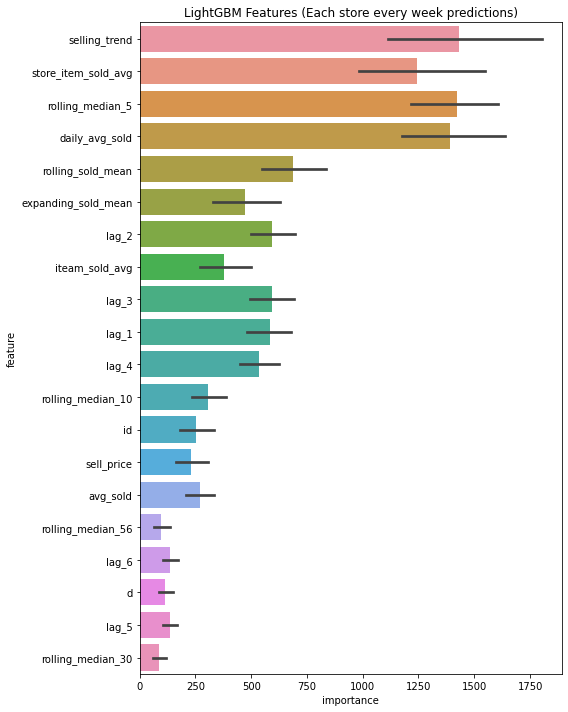

In [20]:
import os
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != 'demand']
for filename in os.listdir('/notebooks/LGBM_Regressor/weekly_model'):
    if 'model_' in filename:
        # load model
        filename=os.path.join('/notebooks/LGBM_Regressor/weekly_model', filename)
        model = joblib.load(filename)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (Each store every week predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)

# Recursive Methord

In [10]:
data = pd.read_pickle('/notebooks/final_preprocessing_data.pkl').pipe(reduce_mem_usage)
data.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,...,expanding_sold_mean,daily_avg_sold,avg_sold,selling_trend,rolling_median_5,rolling_median_10,rolling_median_20,rolling_median_28,rolling_median_30,rolling_median_56
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1001,2,2013-10-25,11339,...,1.179295,2.0,0.615234,1.384766,1.19408,1.19741,1.203621,1.208809,1.210091,1.217574
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1001,0,2013-10-25,11339,...,1.179295,0.0,0.289062,-0.289062,1.19408,1.19741,1.203621,1.208809,1.210091,1.217574


In [11]:
os.chdir('/notebooks/LGBM_Regressor/Reccursive_approach')

In [12]:
!pwd

/notebooks/LGBM_Regressor/Reccursive_approach


In [13]:
from tqdm import tqdm
for col in tqdm(['id','item_id','dept_id','cat_id','store_id','state_id','event_name_1','event_type_1','event_type_2','event_name_2','weekday']):
    data[col] = data[col].astype('category')

100%|██████████| 11/11 [00:32<00:00,  2.93s/it]


In [14]:
d_id = dict(zip(data.id.cat.codes, data.id))
d_item_id = dict(zip(data.item_id.cat.codes, data.item_id))
d_dept_id = dict(zip(data.dept_id.cat.codes, data.dept_id))
d_cat_id = dict(zip(data.cat_id.cat.codes, data.cat_id))
d_store_id = dict(zip(data.store_id.cat.codes, data.store_id))
d_state_id = dict(zip(data.state_id.cat.codes, data.state_id))

In [15]:
cols = data.dtypes.index.tolist()
d_types = data.dtypes.values.tolist()
for i,type in enumerate(d_types):
    if type.name == 'category':
        data[cols[i]] = data[cols[i]].cat.codes

In [16]:
data.drop(['date'],axis=1,inplace=True)

In [17]:
def get_recursion(data):
    lags = [1,2,3,4,5,6,7]
    for lag in lags:
        data["lag_" + str(lag)] = data.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'] ,as_index=False)["demand"].shift(lag).astype(np.float16)
    return data

In [18]:
from tqdm import tqdm
import joblib
import gc
import warnings
warnings.filterwarnings('ignore')
evaluation=pd.DataFrame()
validation=pd.DataFrame()
valid_preds={}
eval_preds={}
data_new=pd.DataFrame()
stores = d_store_id.keys()
stores = d_store_id.keys()
for store in tqdm(stores):
    df = data[data['store_id']==store]
    #Split the data
    count=0
    model = LGBMRegressor(objective ='tweedie',
          tweedie_variance_power=1.5,
          n_estimators=1000,
          learning_rate=0.3,
          subsample=0.8,
          colsample_bytree=0.8,
          max_depth=8,
          num_leaves=50,
          min_child_weight=300
        )
    for week in range(0,28,7):
        count+=1
        print('********Prediction for Store:{}, and week_{}*************'.format(d_store_id[store],count))
        df = get_recursion(df)
        X_train, y_train = df[df['d']<1914+week].drop('demand',axis=1), df[df['d']<1914+week]['demand']
        X_valid, y_valid = df[(df['d']>=1914+week) & (df['d']<=1920+week)].drop('demand',axis=1), df[(df['d']>=1914+week) & (df['d']<=1920+week)]['demand']
        X_test = df[(df['d']>=1942+week) & (df['d']<=1948+week)].drop('demand',axis=1)
        
        #Train and validate
        model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
              eval_metric='rmse', verbose=20, early_stopping_rounds=20)
        y_pred_valid=model.predict(X_valid)
        y_pred_eval=model.predict(X_test)
        X_valid['demand']=y_pred_valid
        X_test['demand']=y_pred_eval
        X_valid=X_valid[['id','d','demand']]
        X_test = X_test[['id','d','demand']]
        validation=validation.append(X_valid)
        evaluation=evaluation.append(X_test)
        del X_train, y_train, y_valid
        data=pd.merge(data, X_valid, on=['id','d'], how='left')
        index = data.index[data['demand_y'].apply(np.isnan)]
        data.loc[index, 'demand_y']=data.loc[index, 'demand_x']
        data.drop('demand_x', axis=1,inplace=True)
        data.rename({'demand_y':'demand'},axis=1, inplace=True)
    filename = 'reccursive_model_'+str(d_store_id[store])+'.pkl'
    # save model
    joblib.dump(model, filename)
    del model,  X_valid
    gc.collect()  

  0%|          | 0/10 [00:00<?, ?it/s]

********Prediction for Store:CA_1, and week_1*************
[20]	training's rmse: 0.224509	training's tweedie: 2.73018	valid_1's rmse: 0.134676	valid_1's tweedie: 3.05093
[40]	training's rmse: 0.144295	training's tweedie: 2.72618	valid_1's rmse: 0.0745119	valid_1's tweedie: 3.04723
[60]	training's rmse: 0.121938	training's tweedie: 2.72604	valid_1's rmse: 0.0583675	valid_1's tweedie: 3.04708
[80]	training's rmse: 0.109269	training's tweedie: 2.72596	valid_1's rmse: 0.0492474	valid_1's tweedie: 3.047
[100]	training's rmse: 0.101686	training's tweedie: 2.72593	valid_1's rmse: 0.04489	valid_1's tweedie: 3.04696
[120]	training's rmse: 0.0912227	training's tweedie: 2.72589	valid_1's rmse: 0.0421322	valid_1's tweedie: 3.04692
[140]	training's rmse: 0.0831078	training's tweedie: 2.72587	valid_1's rmse: 0.0404899	valid_1's tweedie: 3.0469
[160]	training's rmse: 0.0764621	training's tweedie: 2.72585	valid_1's rmse: 0.0400975	valid_1's tweedie: 3.04688
[180]	training's rmse: 0.072198	training's t

 10%|█         | 1/10 [18:43<2:48:30, 1123.34s/it]

********Prediction for Store:CA_2, and week_1*************
[20]	training's rmse: 0.162231	training's tweedie: 2.21146	valid_1's rmse: 0.258595	valid_1's tweedie: 3.11857
[40]	training's rmse: 0.123145	training's tweedie: 2.20769	valid_1's rmse: 0.280973	valid_1's tweedie: 3.11527
********Prediction for Store:CA_2, and week_2*************
[20]	training's rmse: 0.159609	training's tweedie: 2.21832	valid_1's rmse: 0.165732	valid_1's tweedie: 3.23913
[40]	training's rmse: 0.120029	training's tweedie: 2.21461	valid_1's rmse: 0.117673	valid_1's tweedie: 3.23598
[60]	training's rmse: 0.103708	training's tweedie: 2.21447	valid_1's rmse: 0.110887	valid_1's tweedie: 3.23583
********Prediction for Store:CA_2, and week_3*************
[20]	training's rmse: 0.149924	training's tweedie: 2.22633	valid_1's rmse: 0.122679	valid_1's tweedie: 3.26917
[40]	training's rmse: 0.111115	training's tweedie: 2.22235	valid_1's rmse: 0.0780127	valid_1's tweedie: 3.26564
[60]	training's rmse: 0.0964641	training's tw

 20%|██        | 2/10 [36:43<2:26:22, 1097.80s/it]

********Prediction for Store:CA_3, and week_1*************
[20]	training's rmse: 0.328893	training's tweedie: 3.41426	valid_1's rmse: 0.206301	valid_1's tweedie: 3.62433
[40]	training's rmse: 0.235764	training's tweedie: 3.40966	valid_1's rmse: 0.147104	valid_1's tweedie: 3.61999
[60]	training's rmse: 0.185292	training's tweedie: 3.40952	valid_1's rmse: 0.11349	valid_1's tweedie: 3.61984
[80]	training's rmse: 0.166865	training's tweedie: 3.40943	valid_1's rmse: 0.102936	valid_1's tweedie: 3.61975
[100]	training's rmse: 0.148557	training's tweedie: 3.40937	valid_1's rmse: 0.0872203	valid_1's tweedie: 3.61968
[120]	training's rmse: 0.133695	training's tweedie: 3.40933	valid_1's rmse: 0.0803444	valid_1's tweedie: 3.61965
[140]	training's rmse: 0.128305	training's tweedie: 3.4093	valid_1's rmse: 0.0763033	valid_1's tweedie: 3.61962
[160]	training's rmse: 0.117927	training's tweedie: 3.40928	valid_1's rmse: 0.0726577	valid_1's tweedie: 3.6196
[180]	training's rmse: 0.113986	training's tweed

 30%|███       | 3/10 [1:01:23<2:28:25, 1272.21s/it]

********Prediction for Store:CA_4, and week_1*************
[20]	training's rmse: 0.148712	training's tweedie: 1.84014	valid_1's rmse: 0.062106	valid_1's tweedie: 2.17901
[40]	training's rmse: 0.116733	training's tweedie: 1.83701	valid_1's rmse: 0.0405613	valid_1's tweedie: 2.17609
[60]	training's rmse: 0.0961545	training's tweedie: 1.8369	valid_1's rmse: 0.0355038	valid_1's tweedie: 2.17599
[80]	training's rmse: 0.0822248	training's tweedie: 1.83686	valid_1's rmse: 0.032899	valid_1's tweedie: 2.17595
[100]	training's rmse: 0.0705133	training's tweedie: 1.83683	valid_1's rmse: 0.031149	valid_1's tweedie: 2.17593
[120]	training's rmse: 0.0625154	training's tweedie: 1.83681	valid_1's rmse: 0.0301781	valid_1's tweedie: 2.1759
[140]	training's rmse: 0.0546085	training's tweedie: 1.8368	valid_1's rmse: 0.0287237	valid_1's tweedie: 2.17589
[160]	training's rmse: 0.0502529	training's tweedie: 1.83679	valid_1's rmse: 0.0279388	valid_1's tweedie: 2.17588
[180]	training's rmse: 0.0467781	training

 40%|████      | 4/10 [1:49:41<3:11:24, 1914.15s/it]

********Prediction for Store:TX_1, and week_1*************
[20]	training's rmse: 0.176735	training's tweedie: 2.05683	valid_1's rmse: 0.11662	valid_1's tweedie: 2.28513
[40]	training's rmse: 0.124635	training's tweedie: 2.0531	valid_1's rmse: 0.0719967	valid_1's tweedie: 2.28152
[60]	training's rmse: 0.09979	training's tweedie: 2.05298	valid_1's rmse: 0.0578533	valid_1's tweedie: 2.2814
[80]	training's rmse: 0.0885624	training's tweedie: 2.05291	valid_1's rmse: 0.0532667	valid_1's tweedie: 2.28133
[100]	training's rmse: 0.081533	training's tweedie: 2.05286	valid_1's rmse: 0.0547857	valid_1's tweedie: 2.28128
[120]	training's rmse: 0.0713739	training's tweedie: 2.05284	valid_1's rmse: 0.0527859	valid_1's tweedie: 2.28126
[140]	training's rmse: 0.0667348	training's tweedie: 2.05282	valid_1's rmse: 0.0516761	valid_1's tweedie: 2.28124
[160]	training's rmse: 0.0613512	training's tweedie: 2.0528	valid_1's rmse: 0.0512893	valid_1's tweedie: 2.28123
[180]	training's rmse: 0.0559669	training's

 50%|█████     | 5/10 [2:06:12<2:11:46, 1581.32s/it]

********Prediction for Store:TX_2, and week_1*************
[20]	training's rmse: 0.29554	training's tweedie: 2.36516	valid_1's rmse: 0.15771	valid_1's tweedie: 2.61301
[40]	training's rmse: 0.212017	training's tweedie: 2.36124	valid_1's rmse: 0.0997392	valid_1's tweedie: 2.60925
[60]	training's rmse: 0.158047	training's tweedie: 2.36112	valid_1's rmse: 0.0824556	valid_1's tweedie: 2.60913
[80]	training's rmse: 0.140674	training's tweedie: 2.36103	valid_1's rmse: 0.0756433	valid_1's tweedie: 2.60904
[100]	training's rmse: 0.119034	training's tweedie: 2.36099	valid_1's rmse: 0.0709216	valid_1's tweedie: 2.609
[120]	training's rmse: 0.107812	training's tweedie: 2.36095	valid_1's rmse: 0.0684364	valid_1's tweedie: 2.60896
[140]	training's rmse: 0.0983549	training's tweedie: 2.36093	valid_1's rmse: 0.0633561	valid_1's tweedie: 2.60893
[160]	training's rmse: 0.0926481	training's tweedie: 2.36091	valid_1's rmse: 0.0624348	valid_1's tweedie: 2.60892
[180]	training's rmse: 0.0769993	training's 

 60%|██████    | 6/10 [2:12:54<1:18:41, 1180.25s/it]

********Prediction for Store:TX_3, and week_1*************
[20]	training's rmse: 0.255843	training's tweedie: 2.24879	valid_1's rmse: 0.11562	valid_1's tweedie: 2.61025
[40]	training's rmse: 0.195827	training's tweedie: 2.24494	valid_1's rmse: 0.0754867	valid_1's tweedie: 2.60664
[60]	training's rmse: 0.162828	training's tweedie: 2.24481	valid_1's rmse: 0.0668194	valid_1's tweedie: 2.60651
[80]	training's rmse: 0.132809	training's tweedie: 2.24476	valid_1's rmse: 0.0600729	valid_1's tweedie: 2.60645
[100]	training's rmse: 0.11423	training's tweedie: 2.24472	valid_1's rmse: 0.0559104	valid_1's tweedie: 2.60641
[120]	training's rmse: 0.101369	training's tweedie: 2.2447	valid_1's rmse: 0.0540637	valid_1's tweedie: 2.60638
[140]	training's rmse: 0.0925852	training's tweedie: 2.24467	valid_1's rmse: 0.0535141	valid_1's tweedie: 2.60636
[160]	training's rmse: 0.0824355	training's tweedie: 2.24466	valid_1's rmse: 0.0513418	valid_1's tweedie: 2.60635
[180]	training's rmse: 0.0764297	training's

 70%|███████   | 7/10 [2:17:35<44:18, 886.23s/it]   

********Prediction for Store:WI_1, and week_1*************
[20]	training's rmse: 0.128437	training's tweedie: 2.38742	valid_1's rmse: 0.113578	valid_1's tweedie: 2.86382
[40]	training's rmse: 0.0817378	training's tweedie: 2.38393	valid_1's rmse: 0.0780374	valid_1's tweedie: 2.86061
[60]	training's rmse: 0.0727102	training's tweedie: 2.38373	valid_1's rmse: 0.0709945	valid_1's tweedie: 2.8604
[80]	training's rmse: 0.066086	training's tweedie: 2.38366	valid_1's rmse: 0.0640422	valid_1's tweedie: 2.86032
[100]	training's rmse: 0.0625344	training's tweedie: 2.3836	valid_1's rmse: 0.0622511	valid_1's tweedie: 2.86026
[120]	training's rmse: 0.0578395	training's tweedie: 2.38357	valid_1's rmse: 0.0605988	valid_1's tweedie: 2.86022
[140]	training's rmse: 0.0551021	training's tweedie: 2.38354	valid_1's rmse: 0.0576815	valid_1's tweedie: 2.86019
[160]	training's rmse: 0.0524742	training's tweedie: 2.38352	valid_1's rmse: 0.0568607	valid_1's tweedie: 2.86018
[180]	training's rmse: 0.0499663	train

 80%|████████  | 8/10 [2:24:10<24:20, 730.11s/it]

********Prediction for Store:WI_2, and week_1*************
[20]	training's rmse: 0.197657	training's tweedie: 2.45768	valid_1's rmse: 0.138765	valid_1's tweedie: 2.87099
[40]	training's rmse: 0.12943	training's tweedie: 2.45352	valid_1's rmse: 0.0810159	valid_1's tweedie: 2.86716
[60]	training's rmse: 0.109304	training's tweedie: 2.45338	valid_1's rmse: 0.0668394	valid_1's tweedie: 2.86701
[80]	training's rmse: 0.0978313	training's tweedie: 2.45331	valid_1's rmse: 0.0559998	valid_1's tweedie: 2.86694
[100]	training's rmse: 0.0883306	training's tweedie: 2.45328	valid_1's rmse: 0.0501471	valid_1's tweedie: 2.86691
[120]	training's rmse: 0.0831315	training's tweedie: 2.45326	valid_1's rmse: 0.0474508	valid_1's tweedie: 2.86688
[140]	training's rmse: 0.0790303	training's tweedie: 2.45323	valid_1's rmse: 0.0458505	valid_1's tweedie: 2.86686
[160]	training's rmse: 0.0736449	training's tweedie: 2.45321	valid_1's rmse: 0.0438729	valid_1's tweedie: 2.86684
[180]	training's rmse: 0.0699377	train

 90%|█████████ | 9/10 [2:29:59<10:10, 610.84s/it]

********Prediction for Store:WI_3, and week_1*************
[20]	training's rmse: 0.207703	training's tweedie: 2.04349	valid_1's rmse: 0.137717	valid_1's tweedie: 2.40851
[40]	training's rmse: 0.155116	training's tweedie: 2.03961	valid_1's rmse: 0.0876846	valid_1's tweedie: 2.40484
[60]	training's rmse: 0.127235	training's tweedie: 2.03947	valid_1's rmse: 0.0729998	valid_1's tweedie: 2.40469
[80]	training's rmse: 0.113166	training's tweedie: 2.0394	valid_1's rmse: 0.0662728	valid_1's tweedie: 2.40461
[100]	training's rmse: 0.097271	training's tweedie: 2.03938	valid_1's rmse: 0.0587834	valid_1's tweedie: 2.40459
********Prediction for Store:WI_3, and week_2*************
[20]	training's rmse: 0.206371	training's tweedie: 2.04622	valid_1's rmse: 0.190945	valid_1's tweedie: 2.72137
[40]	training's rmse: 0.149736	training's tweedie: 2.04237	valid_1's rmse: 0.132037	valid_1's tweedie: 2.71789
[60]	training's rmse: 0.125874	training's tweedie: 2.04223	valid_1's rmse: 0.12394	valid_1's tweedie:

100%|██████████| 10/10 [2:33:51<00:00, 923.19s/it]


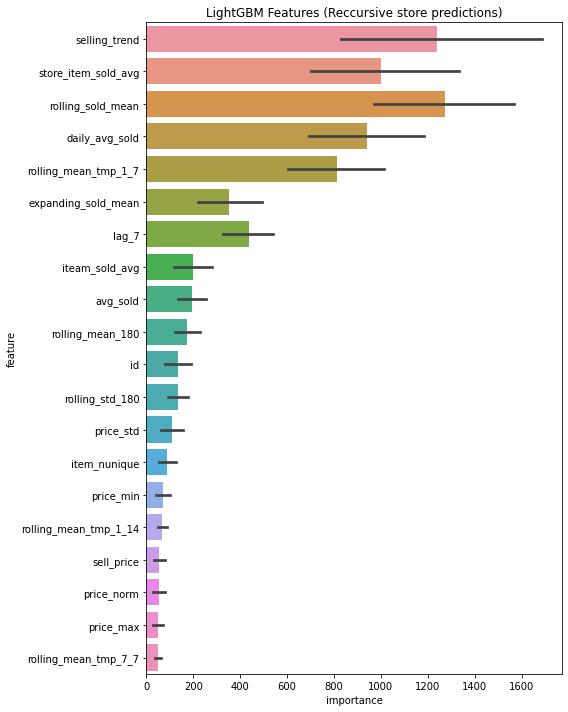

In [22]:
import os
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != 'demand']
for filename in os.listdir('/notebooks/LGBM_Regressor/Reccursive_approach'):
    if 'model_' in filename:
        # load model
        filename=os.path.join('/notebooks/LGBM_Regressor/Reccursive_approach', filename)
        model = joblib.load(filename)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (Reccursive store predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)

In [23]:
actual = True
if actual == False:
    #Get the validation results(We already have them as less than one month left for competition to end)
    validation = data[(data['d']>=1914) & (data['d']<=1941)][['id','d','demand']]
    validation = pd.pivot(validation, index='id', columns='d', values='demand').reset_index()
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
    validation.id = validation.id.map(d_id).str.replace('evaluation','validation')
else:
    #Get the actual validation results
    validation = validation[['id','d','demand']]
    validation = pd.pivot(validation, index='id', columns='d', values='demand').reset_index()
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
    validation.id = validation.id.map(d_id).str.replace('evaluation','validation')
validation.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,2.021381e+00,2.724351e-08,2.424815e-08,1.804653e-08,2.017581e-08,1.003070e+00,1.000792e+00,2.233799e-08,6.004908e+00,...,1.960092,3.002765e+00,9.950899e-01,9.849757e-09,1.145321e-08,7.868789e-09,1.005138e+00,1.141164e-08,9.224068e-09,4.705804e-09
1,FOODS_1_001_CA_2_validation,4.345123e-07,2.755088e+00,3.175992e-07,4.160248e-07,3.206561e-07,9.967296e-01,4.314382e+00,2.227307e-08,2.884233e-08,...,0.999432,2.672590e-08,2.674067e-08,9.968503e-01,1.001623e+00,7.561581e-09,6.696520e-09,9.983888e-01,2.003524e+00,7.068830e-09
2,FOODS_1_001_CA_3_validation,1.020027e+00,5.396254e-07,1.004379e+00,5.330538e-07,7.897754e+00,9.593368e-01,6.942795e-07,5.940146e-08,1.005666e+00,...,1.041335,1.959526e+00,2.056931e+00,1.887822e-08,1.887822e-08,1.022041e+00,2.215499e-08,3.015207e+00,1.997197e+00,1.997197e+00
3,FOODS_1_001_CA_4_validation,1.072534e-09,1.018062e+00,9.145520e-10,9.145520e-10,1.080846e-09,7.130359e-10,1.018166e+00,1.740601e-09,1.885489e-09,...,0.994630,3.322443e-09,2.960628e-09,4.382945e-08,4.382945e-08,9.995716e-01,9.977345e-01,4.687690e-08,4.787082e-08,4.787082e-08
4,FOODS_1_001_TX_1_validation,2.561540e-09,2.557617e-09,9.997964e-01,4.239582e-09,1.001165e+00,6.193815e-09,1.001319e+00,1.000724e+00,1.001140e+00,...,0.998168,9.946207e-01,1.008177e+00,1.001331e+00,4.962308e+00,2.466148e-08,2.001385e+00,2.012407e+00,2.588915e-08,2.012407e+00


In [24]:
evaluation=evaluation[['id','d','demand']]
evaluation['id']=evaluation['id'].map(d_id)
evaluation = pd.pivot(evaluation, index='id', columns='d', values='demand').reset_index()
evaluation.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]
evaluation.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,1.715565e-08,1.578704e-08,1.477638e-08,7.977161e-09,7.657236e-09,7.657236e-09,7.657236e-09,7.632789e-09,7.572871e-09,...,4.122031e-09,4.122031e-09,4.122031e-09,1.922014e-09,1.704359e-09,1.621878e-09,1.621878e-09,1.575957e-09,1.575957e-09,2.367573e-09
1,FOODS_1_001_CA_2_evaluation,3.176763e-07,2.628847e-07,2.640793e-07,2.640793e-07,2.917951e-07,1.369599e-07,1.369599e-07,1.126558e-08,1.089485e-08,...,6.900258e-09,6.900258e-09,6.340655e-09,2.413665e-09,2.413665e-09,2.413665e-09,2.413665e-09,2.413665e-09,2.413665e-09,1.988010e-09
2,FOODS_1_001_CA_3_evaluation,7.112885e-07,7.112885e-07,6.949968e-07,4.543870e-07,4.839304e-07,4.292568e-07,2.213906e-07,1.289216e-08,1.289216e-08,...,1.471241e-07,1.471241e-07,1.471241e-07,6.550017e-09,6.561973e-09,6.550017e-09,6.550017e-09,6.550017e-09,6.185692e-09,6.185692e-09
3,FOODS_1_001_CA_4_evaluation,6.803529e-10,6.803529e-10,6.513748e-10,3.235543e-10,3.244266e-10,3.244266e-10,3.244266e-10,8.949158e-10,8.949158e-10,...,1.686917e-09,1.686917e-09,1.686917e-09,2.495129e-08,2.495129e-08,2.495129e-08,2.495129e-08,2.495129e-08,2.495129e-08,2.495129e-08
4,FOODS_1_001_TX_1_evaluation,1.889942e-08,1.798606e-08,1.419043e-08,1.051876e-08,9.501232e-09,6.741037e-09,3.700940e-09,1.325946e-09,1.354704e-09,...,5.190877e-09,5.190877e-09,5.190877e-09,5.255772e-09,5.255772e-09,5.255772e-09,5.255772e-09,5.104433e-09,5.104433e-09,5.104433e-09


In [25]:
submit = pd.concat([validation,evaluation]).reset_index(drop=True)
submit.to_csv('store_wise_reccursive_lgbm_submission.csv',index=False)